# 线性回归简洁实现
```
最简训练步骤：
1、初始化模型参数: w,b
2、设置超参数: lr,num_epochs
3、前向传播: 计算出y_hat
4、计算出loss: （关于y_hat 与 y 的）squared_loss
5、反向传播，计算梯度: （参数w、b关于loss函数的梯度）【注意：反向传播之前必须清除上一个 epoch 保存的梯度】
6、使用梯度，更新参数: Optimization Algorithm （sgd、Adagrad、Adam等） 【注意：with torch.no_grad():】
7、重复步骤3-6，num_epochs次。
```

In [82]:
import torch
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置plt可以显示中文字体，否则会显示乱码
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)

In [83]:
"""
生成加入噪声的测试数据
生成y=Xw+b+噪声
"""
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w))) # 高斯分布(正态分布)
    # X = torch.rand((num_examples,len(w))) # 均匀分布
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

# 生成测试数据
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
features.shape,labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

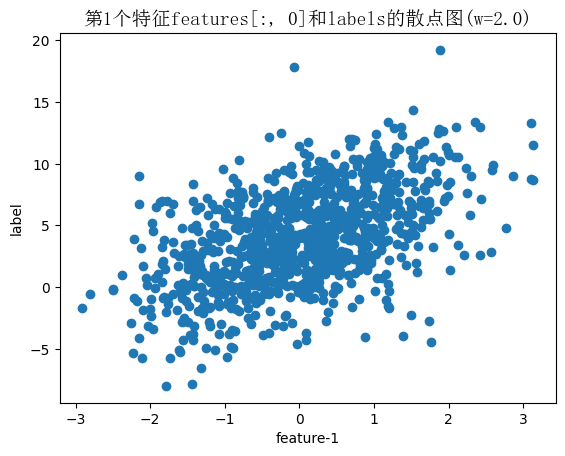

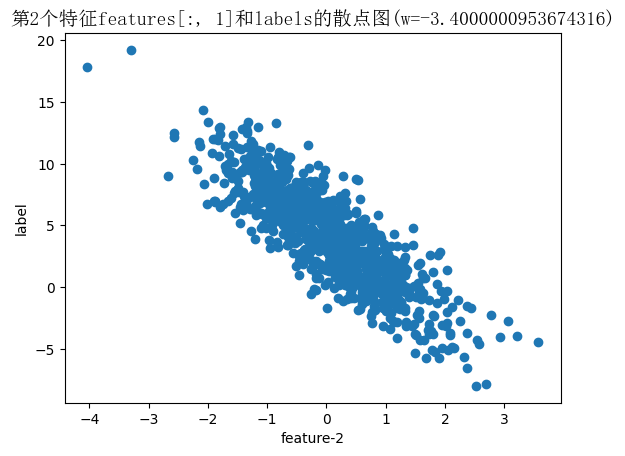

In [84]:
%matplotlib inline

"""
查看测试数据散点图
"""
for i in range(len(true_w)):
    plt.scatter(features[:, i], labels)
    plt.xlabel(f"feature-{i+1}")
    plt.ylabel(f"label")
    plt.title(f"第{i + 1}个特征features[:, {i}]和labels的散点图(w={true_w[i]})", fontproperties=font)
    plt.show()


In [85]:
"""
调用框架中现有的API来读取数据
构造一个PyTorch数据迭代器
"""
def load_array(data_arrays,batch_size,is_train=True):
    data_set = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(data_set,batch_size,shuffle=is_train)

batch_size = 3
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[ 0.6915,  0.5204],
         [-0.2777, -1.1221],
         [ 0.3164,  0.8154]]),
 tensor([[3.8174],
         [7.4534],
         [2.0609]])]

In [86]:
"""
定义模型
在PyTorch中，全连接层在Linear类中定义。
值得注意的是，我们将两个参数传递到nn.Linear中。
第一个指定输入特征形状，即2;
第二个指定输出特征形状，输出特征形状为单个标量，因此为1。
"""
net = torch.nn.Sequential(torch.nn.Linear(2, 1))

In [87]:
"""
# 初始化模型参数
# 深度学习框架通常有预定义的方法来初始化参数。
# 在这里，我们指定每个权重参数应该从均值为0、标准差为0.01的正态分布中随机采样， 偏置参数将初始化为零。
"""
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)


tensor([0.])

In [88]:
"""
# 定义损失函数
# 计算均方误差使用的是MSELoss类，也称为平方范数。 默认情况下，它返回所有样本损失的平均值.
"""
loss = torch.nn.MSELoss()
# loss = nn.SmoothL1Loss(beta=1.0)

In [89]:
"""
定义优化算法
PyTorch在optim模块中实现了该算法的许多变种。
当我们实例化一个SGD实例时，我们要指定优化的参数 （可通过net.parameters()从我们的模型中获得）以及优化算法所需的超参数字典lr。
"""
lr = 0.03
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [90]:
"""
# 训练
"""
num_epochs = 10
batch_size = 32
data_iter = load_array((features, labels), batch_size=batch_size)
# 在使用data_iter函数时，我们需要注意最后一个批量可能比其他批量更小，需要特殊处理。
train_all_dataset_loss_list = [] # 用于保存历史loss均值

for epoch in range(num_epochs):
    for X, y in data_iter:
        # print(y.shape)
        l = loss(net(X) ,y) # 通过调用net(X)生成预测并计算损失l（前向传播）
        optimizer.zero_grad() # 反向传播之前必须清除上一个 epoch 保存的梯度
        l.backward() # 通过进行反向传播来计算梯度
        # print(f"w 的梯度：{net[0].weight.grad}") # 查看模型中的权重张量的梯度,需要注意的是，只有在调用 backward() 方法之后，才能查看张量的梯度。
        # print(f"w 变化: {net[0].weight.data} ->",end='')  # 随机梯度下降算法SGD 优化前的参数值
        optimizer.step() # 通过调用优化器来更新模型参数
        # print(f" {net[0].weight.data}") # 随机梯度下降算法SGD 优化后的参数值w
    with torch.no_grad():
        l = loss(net(features), labels)
        print(f'epoch {epoch + 1}, loss {l:f}')
        train_all_dataset_loss_list.append(l.item())

w = net[0].weight.data
print(f"w 的真实值: {true_w}, w 的估计值: {w.reshape(true_w.shape)}")
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print(f"b 的真实值: {true_b}, b 的估计值: {b}")
print('b的估计误差：', true_b - b)

epoch 1, loss 0.711738
epoch 2, loss 0.016339
epoch 3, loss 0.000461
epoch 4, loss 0.000106
epoch 5, loss 0.000097
epoch 6, loss 0.000097
epoch 7, loss 0.000096
epoch 8, loss 0.000096
epoch 9, loss 0.000096
epoch 10, loss 0.000096
w 的真实值: tensor([ 2.0000, -3.4000]), w 的估计值: tensor([ 1.9997, -3.4002])
w的估计误差： tensor([0.0003, 0.0002])
b 的真实值: 4.2, b 的估计值: tensor([4.1998])
b的估计误差： tensor([0.0002])


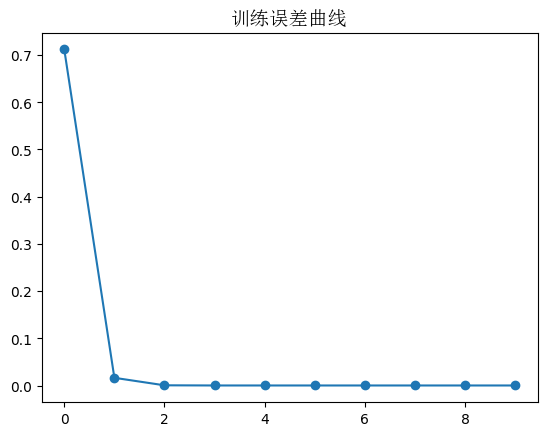

In [92]:
# 画图-训练误差曲线
train_all_dataset_loss_list_Y = train_all_dataset_loss_list
train_all_dataset_loss_list_X = [i for i in range(len(train_all_dataset_loss_list_Y))]
plt.plot(train_all_dataset_loss_list_X, train_all_dataset_loss_list_Y,marker='o')
plt.title("训练误差曲线", fontproperties=font)
plt.show()
